In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from alrd.run_spot import SessionBuffer, DataBuffer, TransitionData, StateData
from alrd.spot_gym.model.robot_state import SpotState

"""
Analyse transitions.

"""

file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240705-142837/session_buffer.pickle"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

transitions = data.data_buffers[0].transitions
states = data.data_buffers[0].states

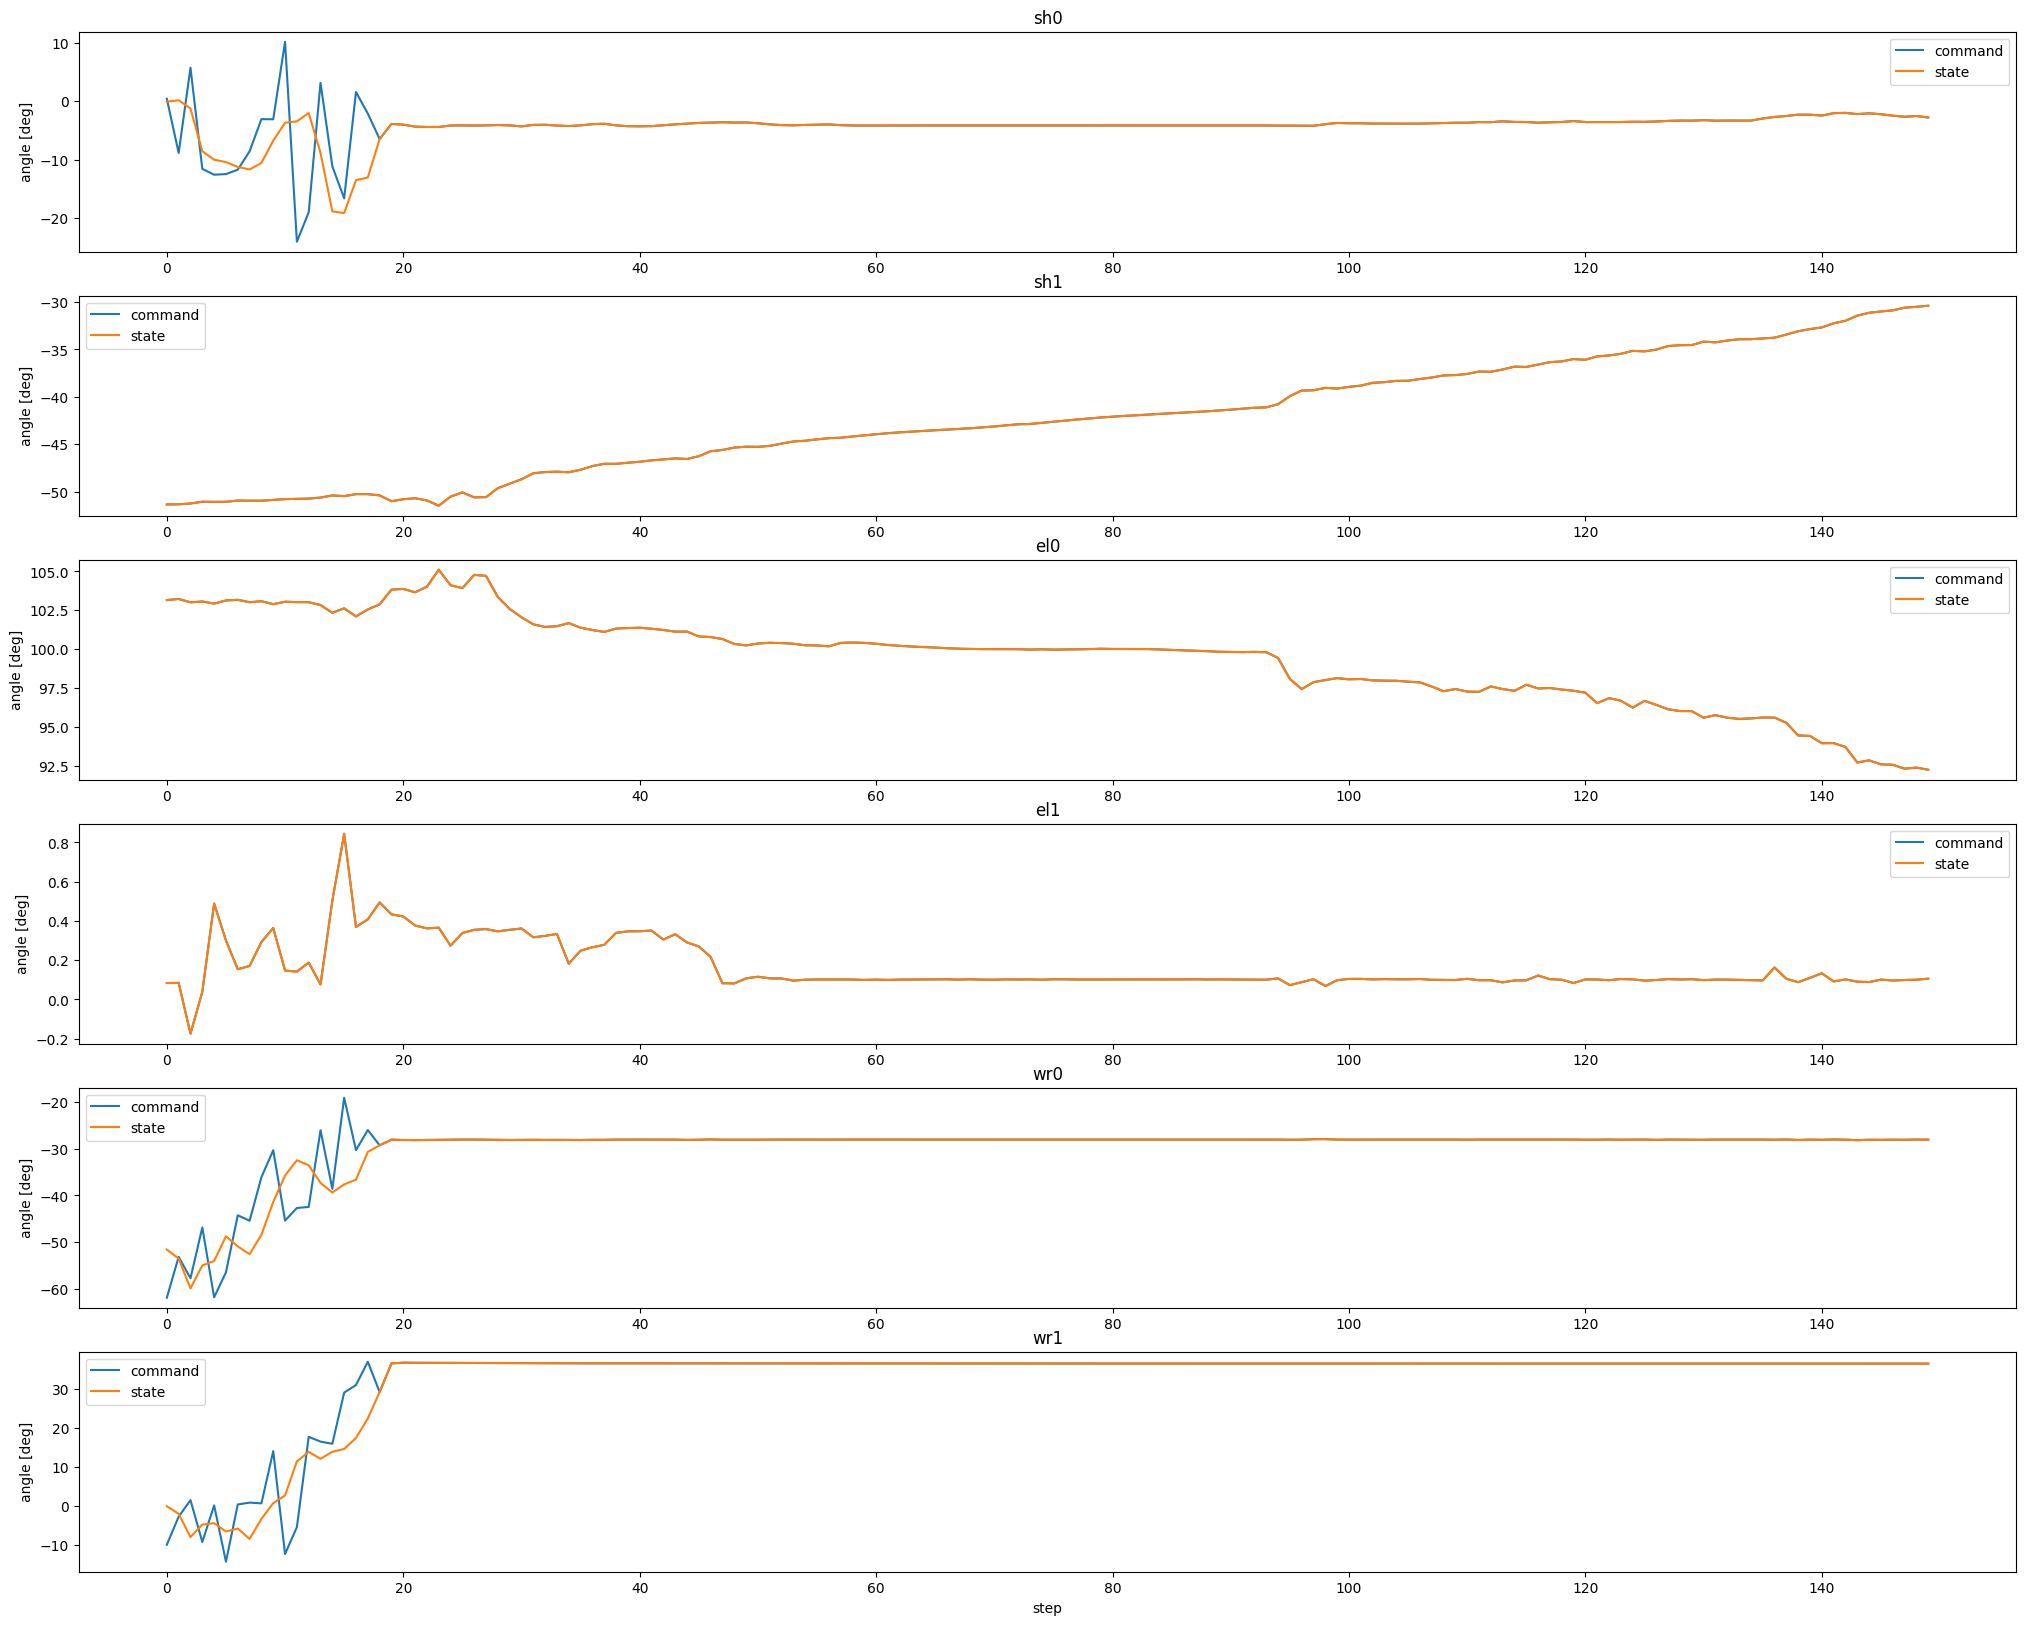

In [8]:
# command tracking analysis for arm joint commands

# get arm joint commands
arm_joint_commands = [transition.cmd.commanded_arm_joint_positions for transition in transitions]
command_steps = [transition.step for transition in transitions]

# get arm joint states
arm_joint_states = [state.last_state.arm_joint_positions for state in states]
state_steps = [state.step for state in states]

# cut off at 150
arm_joint_commands = arm_joint_commands[:150]
command_steps = command_steps[:150]
arm_joint_states = arm_joint_states[:150]
state_steps = state_steps[:150]


# plot seperately in subplot for each joint (sh0, sh1, el0, el1, wr0, wr1)
fig, axs = plt.subplots(6, 1, figsize=(25, 20))
joint_names = ["sh0", "sh1", "el0", "el1", "wr0", "wr1"]
for i in range(6):
    axs[i].plot(command_steps, [np.rad2deg(command[i]) for command in arm_joint_commands], label="command")
    axs[i].plot(state_steps, [np.rad2deg(state[i]) for state in arm_joint_states], label="state")
    axs[i].set_title(joint_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 5:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("angle [deg]")

plt.show()

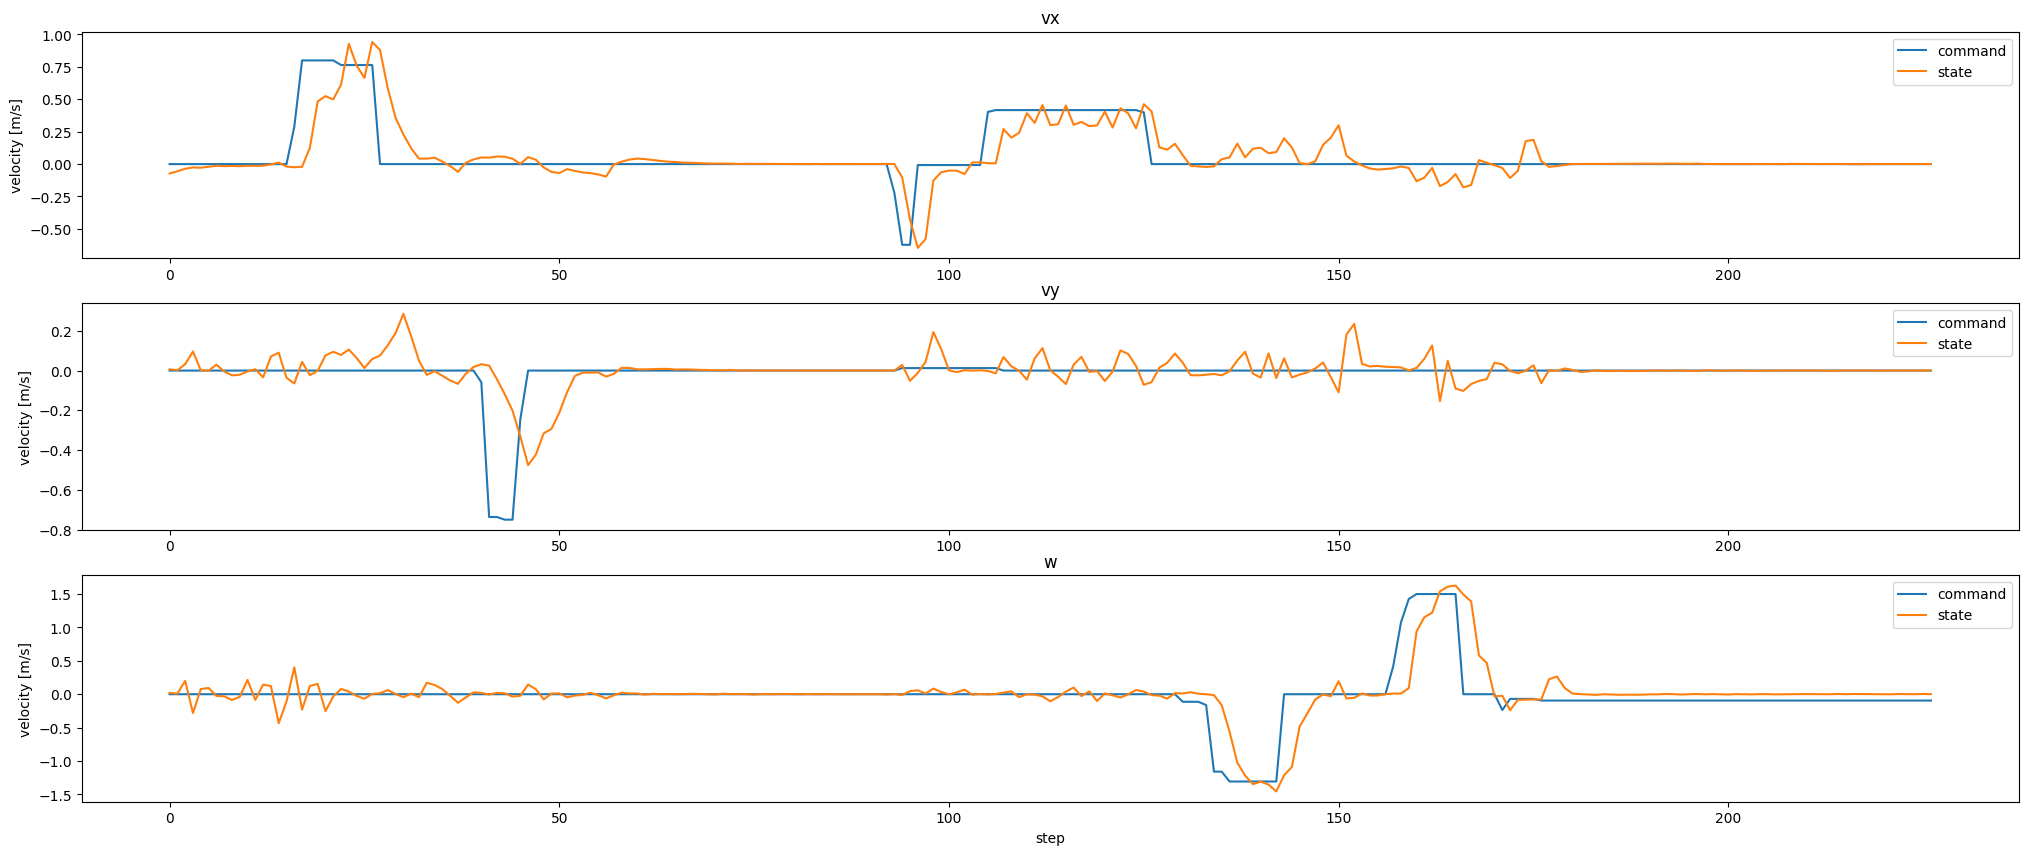

In [15]:
# command tracking analysis for body commands

# get body commands
body_commands = [[transition.cmd.vx, transition.cmd.vy, transition.cmd.w] for transition in transitions]
command_steps = [transition.step for transition in transitions]

# get body states
body_states = [[state.last_state.velocity_of_body_in_vision[0], state.last_state.velocity_of_body_in_vision[1], state.last_state.velocity_of_body_in_vision[5]] for state in states]
state_steps = [state.step for state in states]

# plot seperately in subplot for vx, vy, w
fig, axs = plt.subplots(3, 1, figsize=(25, 10))
body_names = ["vx", "vy", "w"]
for i in range(3):
    axs[i].plot(command_steps, [command[i] for command in body_commands], label="command")
    axs[i].plot(state_steps, [state[i] for state in body_states], label="state")
    axs[i].set_title(body_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("velocity [m/s]")

plt.show()

In [8]:
# test forward kinematics

from alrd.spot_gym.utils.spot_arm_fk import SpotArmFK

spot_arm_fk = SpotArmFK()

# get arm joint positions
arm_joint_positions = [state.last_state.arm_joint_positions for state in states]
state_steps = [state.step for state in states]

# get gt arm end effector positions
gt_ee_positions = [[state.last_state.pose_of_hand[0], state.last_state.pose_of_hand[1], state.last_state.pose_of_hand[2]] for state in states]

# get fk arm end effector positions
fk_ee_positions_cs = [spot_arm_fk.get_ee_position([arm_joint_position[0], arm_joint_position[1], arm_joint_position[2], arm_joint_position[3], arm_joint_position[4], arm_joint_position[5]]) for arm_joint_position in arm_joint_positions]
fk_ee_positions = np.array([dm.full().flatten() for dm in fk_ee_positions_cs])

# plot the fk and gt end effector positions
fig, axs = plt.subplots(3, 1, figsize=(25, 10))
ee_names = ["x", "y", "z"]
for i in range(3):
    axs[i].plot(state_steps, [gt_ee_position[i] for gt_ee_position in gt_ee_positions], label="gt")
    axs[i].plot(state_steps, [fk_ee_position[i] for fk_ee_position in fk_ee_positions], label="fk")
    axs[i].set_title(ee_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("position [m]")

plt.show()

In [19]:
# test inverse kinematics

from alrd.spot_gym.utils.spot_arm_ik import SpotArmIK

spot_arm_ik = SpotArmIK()

# take only first 100 states 
states_new = states[:10]
state_steps = [state.step for state in states_new]

# get gt arm joint positions and gt end effector positions
gt_arm_joint_positions = [state.last_state.arm_joint_positions for state in states_new]
gt_ee_positions = [[state.last_state.pose_of_hand[0], state.last_state.pose_of_hand[1], state.last_state.pose_of_hand[2]] for state in states_new]

# get target end effector positions
target_ee_positions = gt_ee_positions[1:]
state_steps_shifted = state_steps[1:]

# get ik arm joint positions
ik_arm_joint_positions = [spot_arm_ik.calculate_ik(np.array(target_ee_position), np.array(arm_joint_position)) for arm_joint_position, target_ee_position in zip(gt_arm_joint_positions, target_ee_positions)]

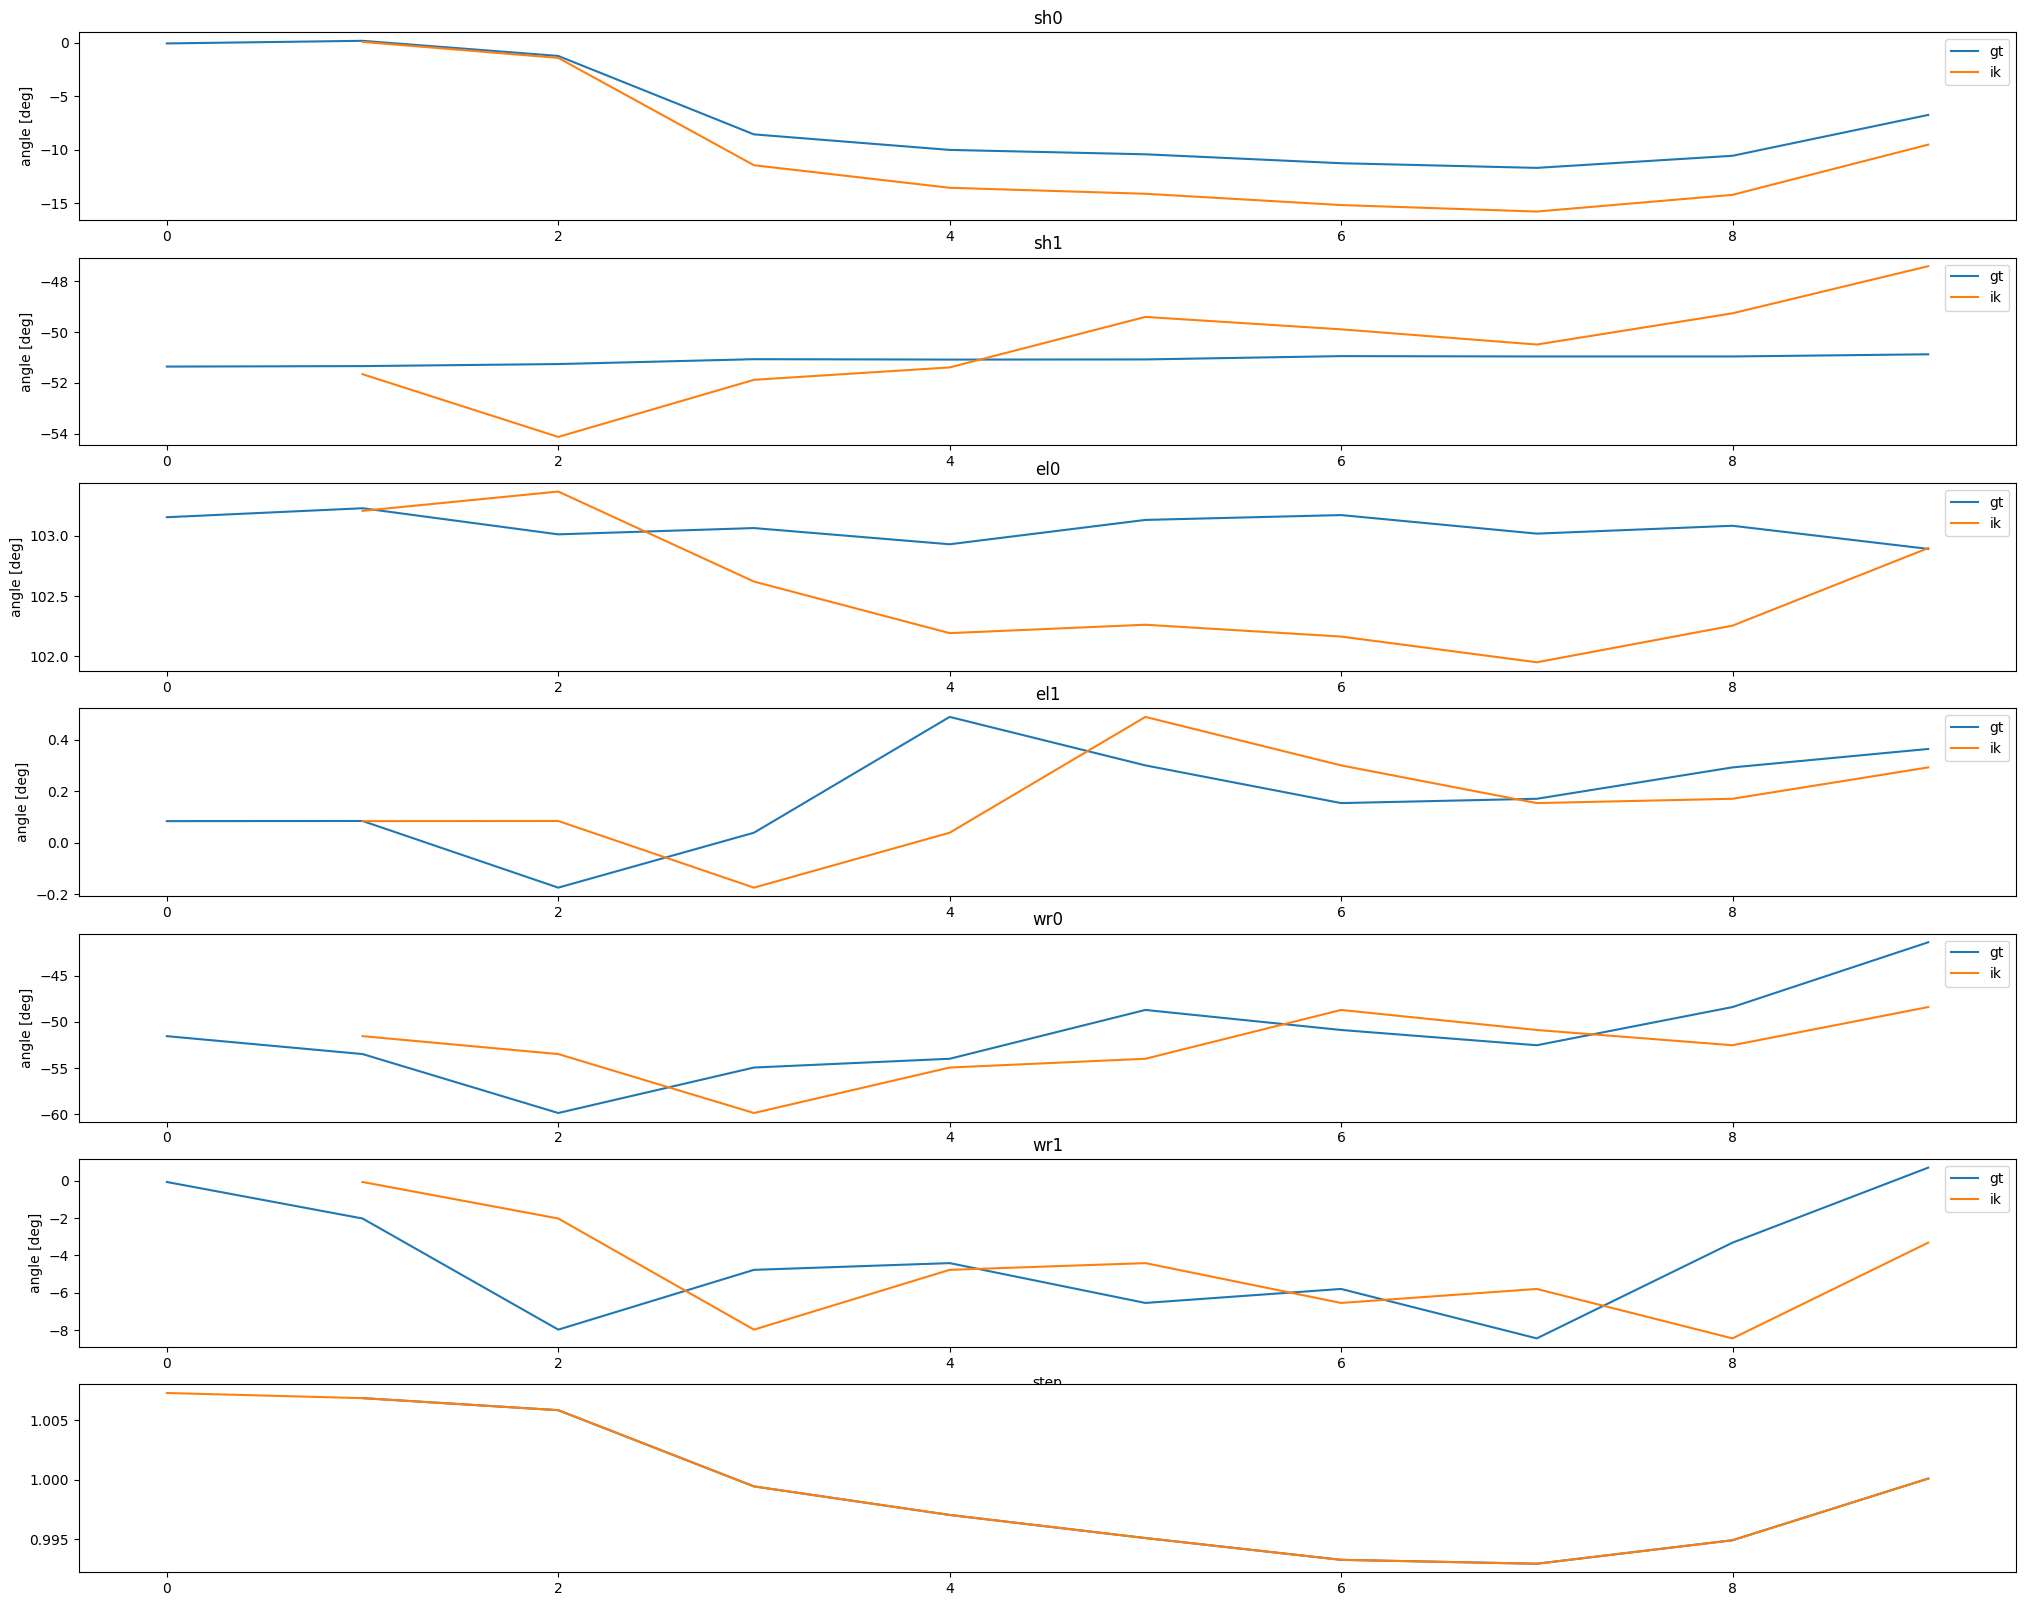

In [21]:
# plot the ik and gt arm joint positions
fig, axs = plt.subplots(7, 1, figsize=(25, 20))
joint_names = ["sh0", "sh1", "el0", "el1", "wr0", "wr1", "ee target"]
for i in range(6):
    axs[i].plot(state_steps, [np.rad2deg(gt_arm_joint_position[i]) for gt_arm_joint_position in gt_arm_joint_positions], label="gt")
    axs[i].plot(state_steps_shifted, [np.rad2deg(ik_arm_joint_position[i]) for ik_arm_joint_position in ik_arm_joint_positions], label="ik")
    axs[i].set_title(joint_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 5:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("angle [deg]")

# plot the target end effector positions
axs[6].plot(state_steps_shifted, [target_ee_position[0] for target_ee_position in target_ee_positions], label="target x")
axs[6].plot(state_steps, [gt_ee_position[0] for gt_ee_position in gt_ee_positions], label="curr y")
axs[6].legend()
